In [1]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import time
import dill as pickle

from IPython.display import clear_output

import dali.core as D
import dali
from dali.data import Lines, Process, DiscoverFiles, BatchBenefactor, IdentityReducer
from dali.data.batch import TranslationBatch
from dali.data.translation import TranslationFiles, TranslationMapper, build_vocabs, iterate_examples
from dali.utils.scoring import bleu, ErrorTracker
from dali.utils import (
    Vocab,
    Solver,
    median_smoothing,
    subsample,
    Throttled,
    pickle_globals,
    unpickle_globals,
)
from dali import beam_search

%matplotlib inline

In [3]:
GPU_ID = 0
D.config.default_device = 'gpu'
D.config.default_gpu    = GPU_ID
print(D.config.gpu_id_to_name(GPU_ID))

b'GeForce GTX 780 Ti'


# (Optional) continue running previous attempt 

In [4]:
RELEVANT_VARIABLES = ["model", "vocabs", "solver", "data", "train_error", "validate_error"]
if False:
    unpickle_globals("/home/sidor/tmp/translation_overfeat")
    params = model.parameters()

# Data loading

In [5]:
# dataset
TRAIN_PATH    = "/home/sidor/datasets/translation/train/fr_en/europarl/"
VALIDATE_PATH = "/home/sidor/datasets/translation/validation/fr_en/europarl/"
FROM_LANG = "en"
TO_LANG   = "fr"
FROM_VOCAB_SIZE = 20000
TO_VOCAB_SIZE   = 20000

# batching
MINIBATCH = 64
SENTENCE_LENGTH_BOUNDS = (None, 40)
SENTENCES_UNTIL_MINIBATCH = 1000 * MINIBATCH

# network sizes
INPUT_SIZE = 512
HIDDENS = [512,512,512,512]
SOFTMAX_INPUT = 512

In [6]:
# you can press stop at any time if you think enough samples were collected.
vocabs = build_vocabs(TRAIN_PATH, FROM_LANG, TO_LANG, from_max_size=FROM_VOCAB_SIZE, to_max_size=TO_VOCAB_SIZE)
print (FROM_LANG + " vocabulary containts", len(vocabs[0]), "words")
print (TO_LANG   + " vocabulary containts", len(vocabs[1]), "words")

Impatient User Detected, file processing halted, proceeding to build vocab.
en vocabulary containts 17882 words
fr vocabulary containts 20002 words


In [6]:
p = Process(files=TranslationFiles(VALIDATE_PATH, FROM_LANG, TO_LANG),
            mapper=TranslationMapper(sentence_bounds=SENTENCE_LENGTH_BOUNDS),
            reducer=IdentityReducer())
validation_pairs = list(p)

In [7]:
def create_dataset_iterator(dataset, sentences_until_minibatch=SENTENCES_UNTIL_MINIBATCH):
    return iterate_examples(dataset, FROM_LANG, TO_LANG, vocabs, 
                            minibatch_size=MINIBATCH,
                            sentence_length_bounds=SENTENCE_LENGTH_BOUNDS,
                            sentences_until_minibatch=sentences_until_minibatch)

validation_batches = list(create_dataset_iterator(VALIDATE_PATH, MINIBATCH))

# Model definition 

In [8]:
class TranslationModel(object):
    def __init__(self, input_size, hiddens, 
                       encoder_vocab_size, decoder_vocab_size,
                       softmax_input_size=None, dtype=np.float32):
        self.input_size = input_size
        self.hiddens    = hiddens
        self.encoder_vocab_size = encoder_vocab_size
        self.decoder_vocab_size = decoder_vocab_size
        self.softmax_input_size = softmax_input_size
        self.dtype = dtype
        
        self.encoder_embedding = D.random.uniform(-0.05, 0.05, (encoder_vocab_size, input_size), dtype=dtype)
        self.decoder_embedding = D.random.uniform(-0.05, 0.05, (decoder_vocab_size, input_size), dtype=dtype)
        
        self.encoder_lstm    = D.StackedLSTM(input_size, hiddens, memory_feeds_gates=True, dtype=dtype)
        self.decoder_lstm    = D.StackedLSTM(input_size, hiddens, memory_feeds_gates=True, dtype=dtype)
        
        if self.softmax_input_size is not None:
            self.predecoder = D.StackedInputLayer(self.hiddens, self.softmax_input_size)
            self.decoder = D.Layer(self.softmax_input_size, decoder_vocab_size, dtype=dtype)
        else:    
            self.decoder = D.Layer(hiddens[-1], decoder_vocab_size, dtype=dtype)
    
    def decode_state(self, state):
        if self.softmax_input_size is not None:
            decoder_input = self.predecoder.activate([s.hidden for s in state])
        else:
            decoder_input = state[-1].hidden
        return self.decoder.activate(decoder_input)
        
    def error(self, batch):
        error = D.Mat(1,1)
        state = self.encoder_lstm.initial_states()
        for ts in range(batch.timesteps):
            inputs  = batch.inputs(ts)
            targets = batch.targets(ts)
            if ts < batch.from_timesteps:
                assert targets is None
                encoded = self.encoder_embedding[inputs]
                state = self.encoder_lstm.activate(encoded, state)
            else:
                assert inputs is None
                decoded = self.decode_state(state)
                # mask the error - only for the relevant sentences
                tstep_error = batch.masks(ts).T() * D.MatOps.softmax_cross_entropy(decoded, targets)
                #tstep_error = D.MatOps.softmax_cross_entropy(decoded, targets)
                error = error + tstep_error.sum()
                # feedback the predictions
                if ts + 1 != batch.timesteps:
                    # for the last timestep encoding is not necessary
                    encoded = self.decoder_embedding[targets]
                    state = self.decoder_lstm.activate(encoded, state)

        return error
    
    def predict(self, input_sentence, **kwargs):
        with D.NoBackprop():
            state = self.encoder_lstm.initial_states()
            for word_idx in input_sentence:
                encoded = self.encoder_embedding[word_idx]
                state = self.encoder_lstm.activate(encoded, state)
            def candidate_scores(state):
                decoded = self.decode_state(state)
                return D.MatOps.softmax(decoded).log()
            def make_choice(state, candidate_idx):
                encoded = self.decoder_embedding[candidate_idx]
                return self.decoder_lstm.activate(encoded, state)

            return beam_search(state,
                               candidate_scores,
                               make_choice,
                               **kwargs)
    
    def parameters(self):
        ret = ([self.encoder_embedding,
               self.decoder_embedding]      
            + self.encoder_lstm.parameters() 
            + self.decoder_lstm.parameters() 
            + self.decoder.parameters())
        if self.softmax_input_size is not None:
            ret.extend(self.predecoder.parameters())
        return ret

In [9]:
def calculate_bleu(model, validation_pairs, beam_width=5, debug=False):
    references = []
    hypotheses = []
    for input_sentence, reference_translation in validation_pairs:
        references.append(" ".join(reference_translation))
        from_vocab, to_vocab = vocabs
        encoded_input = from_vocab.encode(list(reversed(input_sentence)), add_eos=False)
        
        predicted = model.predict(encoded_input, 
                     eos_symbol=to_vocab.eos,
                     max_sequence_length=SENTENCE_LENGTH_BOUNDS[1] + 1,
                     blacklist=[], #to_vocab.unk],
                     beam_width=beam_width)[0].solution
        decoded_prediction = " ".join(to_vocab.decode(predicted, strip_eos=True))
        hypotheses.append(decoded_prediction)
        if debug:
            print ("INPUT:      ", " ".join(input_sentence))
            print ("REFERENCE:  ", " ".join(reference_translation))
            print ("PREDICTION: ", decoded_prediction)
            print ("")
    return bleu(references, hypotheses)

In [ ]:
calculate_bleu(model, validation_pairs[-50:], 5, debug=True)

INPUT:       Finally , and in particular , expectations in the regions about this initiative are high given that small towns not eligible for Objective 2 funding are hoping to obtain compensation through INTERREG !
REFERENCE:   Enfin et surtout , en région , les attentes vis - à - vis de cette initiative sont fortes , les localités non éligibles à l ' objectif 2 espérant trouver des compensations grâce à Interreg !
PREDICTION:  Enfin , il y a des **UNK** à l ' avenir , à l ' avenir , à l ' Europe des pays qui se **UNK** à l ' industrie **UNK** ou **UNK** ?

INPUT:       The challenges are therefore immense . The integration of the border regions will be an essential element in the development of a future European regional development policy !
REFERENCE:   Les enjeux sont donc importants : l ' intégration des régions frontalières constituera un élément essentiel de l ' élaboration d ' une future politique d ' aménagement du territoire européen !
PREDICTION:  L ' élargissement est - à - 

In [13]:
def show_reconstructions(model, example_pair):
    from_words, to_words = example_pair
    from_vocab, to_vocab = vocabs
    from_with_unk = ' '.join(from_vocab.decode(from_vocab.encode(from_words)))
    to_with_unk   = ' '.join(to_vocab.decode(to_vocab.encode(to_words)))
    print('TRANSLATING: %s' % from_with_unk)
    print('REFERENCE:   %s' % to_with_unk)
    print('')
    for solution, score, _ in model.predict(from_vocab.encode(list(reversed(from_words)), add_eos=False), 
                                           eos_symbol=to_vocab.eos,
                                           max_sequence_length=SENTENCE_LENGTH_BOUNDS[1] + 1):
        score = math.exp(score.w[0])
        # reveal the unks
        solution = ' '.join(to_vocab.decode(solution, False))
        print('    %f => %s' % (score, to_vocab.decode(solution, True)))

# Create new experiment 

In [14]:
model  = TranslationModel(INPUT_SIZE, HIDDENS, len(vocabs[0]), len(vocabs[1]), softmax_input_size=SOFTMAX_INPUT)

In [15]:
params = model.parameters()
solver = Solver("sgd", learning_rate=0.003)

In [16]:
data             = []
train_error      = ErrorTracker()
validate_error   = ErrorTracker()

# Training

In [21]:
D.config.clear_gpu()

total_time  = 0.0
num_words, num_batches = 0, 0

t = Throttled(10)

while True:
    total_time  = 0.0
    num_words, num_batches = 0, 0
        
    #if len(error_evolution) >= 5 and hasattr(solver, 'step_size'):
    #solver.step_size = solver.step_size / 1.5
    if solver.solver_type == 'adagrad':
        solver.reset_caches(params)

    for batch in data:            
        batch_start_time = time.time()
        error = model.error(batch)
        (error / batch.examples).grad()
        D.Graph.backward()
#         solver.set_lr_multiplier(model.encoder_embedding, batch.examples)
#         solver.set_lr_multiplier(model.decoder_embedding, batch.examples)
        solver.step(params)
        batch_end_time = time.time()

        train_error.append(error / batch.to_tokens)
        
        total_time += batch_end_time - batch_start_time
        num_words   += batch.from_tokens + batch.to_tokens
        num_batches += 1
        
        if num_batches % 10 == 0:
            val_batch = random.choice(validation_batches)
            with D.NoBackprop():
                validate_error.append(model.error(val_batch) / val_batch.to_tokens)

        if t.should_i_run() and num_batches > 0 and abs(total_time) > 1e-6:
            clear_output()
            print('Epochs completed:  ', train_error.num_epochs())
            print('Error:             ', train_error.recent(10))
            print('Time per batch:    ', total_time  / num_batches)
            print('Words per second:  ', num_words   / total_time )
            print('Batches processed: ', num_batches)
            if hasattr(solver, 'step_size'):
                print('Solver step size:  ', solver.step_size)
            show_reconstructions(model, random.choice(validation_pairs))
            sys.stdout.flush()
                
        # free memory as soon as possible
        del batch

    train_error.finalize_epoch()
    validate_error.finalize_epoch()
    if train_error.num_epochs() > 0:
        pickle_globals("/home/sidor/tmp/lst_hope/epoch_%d" % (train_error.num_epochs(),),
                       RELEVANT_VARIABLES)
            
    data = create_dataset_iterator(TRAIN_PATH)

Epochs completed:   4
Error:              3.68634212017
Time per batch:     0.5923945674974631
Words per second:   4781.141880156646
Batches processed:  19465
TRANSLATING: I would like to thank the rapporteur , who really has **UNK** away tirelessly at this **UNK** task , in conjunction with the Commissioner of course .
REFERENCE:   Je voudrais remercier le rapporteur qui , inlassablement , a tenté de dégager ce dossier , en coopération , bien sûr , avec la commissaire .

    0.000000 => Je voudrais remercier M . **UNK** pour le rapporteur pour le rapport de M . **UNK** **UNK** pour son rapport . **EOS**
    0.000000 => Je voudrais remercier M . **UNK** pour le rapporteur pour le rapport de M . **UNK** **UNK** que la proposition de M . **UNK** **UNK** . **EOS**
    0.000000 => Je voudrais remercier M . **UNK** pour le rapporteur pour le rapport de M . **UNK** **UNK** que la proposition de M . **UNK** **UNK** de la parole . **EOS**
    0.000000 => Je voudrais remercier M . **UNK** pour 

KeyboardInterrupt: 

In [24]:
pickle_globals("/home/sidor/tmp/translation_overfeat",RELEVANT_VARIABLES)

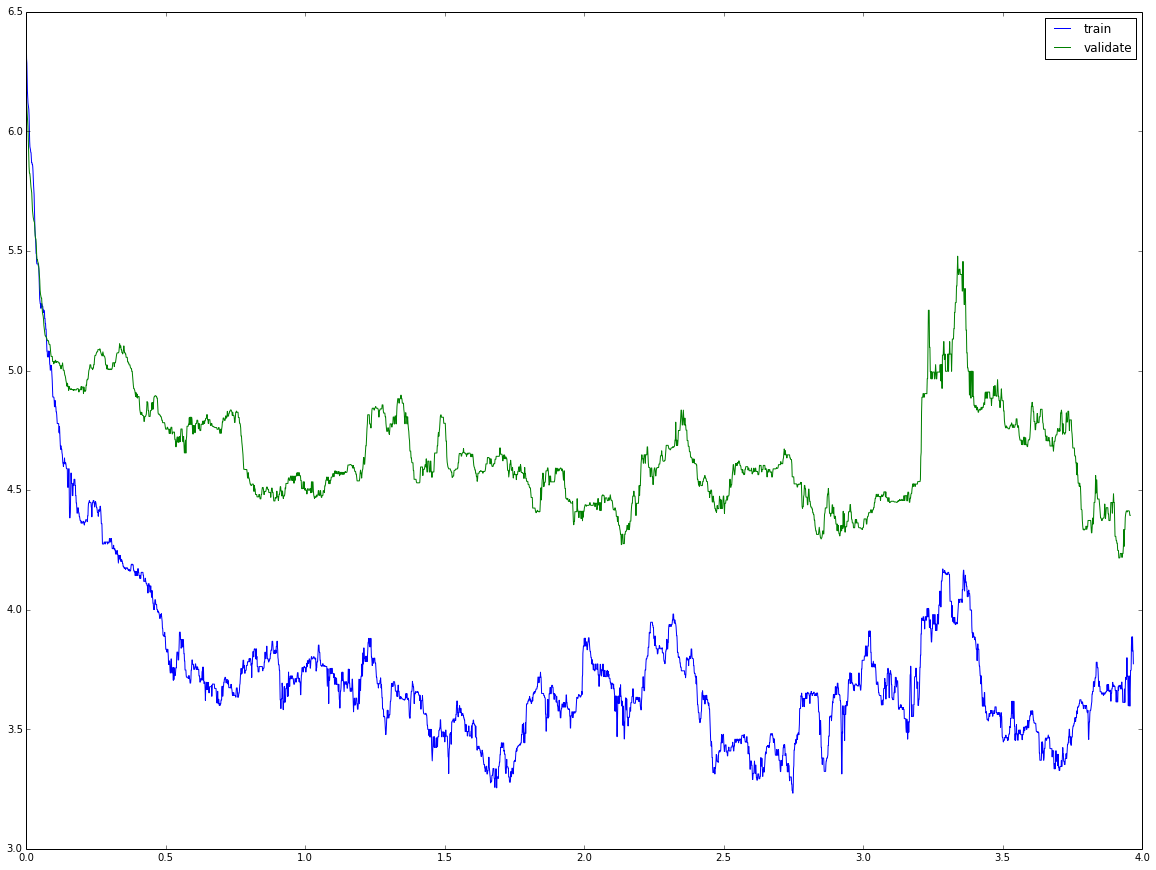

In [22]:
train_error.__class__ = ErrorTracker
validate_error.__class__ = ErrorTracker

plt.figure(figsize=(20,15))

plt.plot(*train_error.raw(), label="train")
plt.plot(*validate_error.raw(), label="validate")
plt.legend()

In [35]:
x, y = validate_error.raw()
print(train_error.error_evolution)

[[8.0048237, 7.9938869, 7.9698668, 7.9363565, 7.8941002, 7.8472652, 7.7633882, 7.7099671, 7.6194835, 7.4893293, 7.3790278, 7.1501489, 7.021059, 6.7153354, 6.9089489, 6.6402268, 6.3901644, 6.2750697, 6.2791896, 6.4190984, 6.4118695, 6.3319311, 6.1173091, 6.1364055, 6.216011, 6.1761017, 6.1015244, 6.1899629, 6.1414409, 6.3002682, 6.0410399, 6.0457573, 6.1572652]]


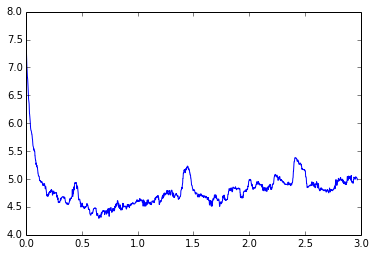

In [14]:
# canoe trip lr=0.0001

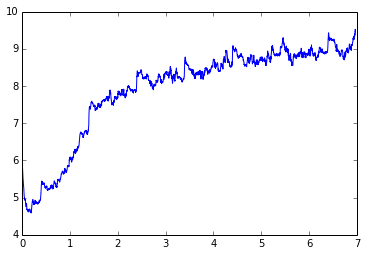

In [14]:
# canoe trip, lr = 0.001

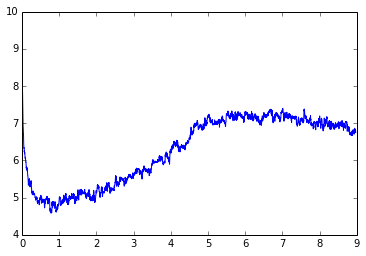

In [13]:
# 0.02 learning rate Jonathan's weights, divide by 1.5 every epoch (starting at fifth)

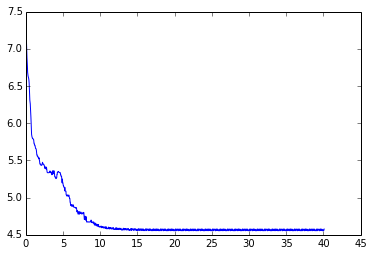

In [575]:
# 0.3 learning rate Jonathan's weights, divide by 2 every epoch 

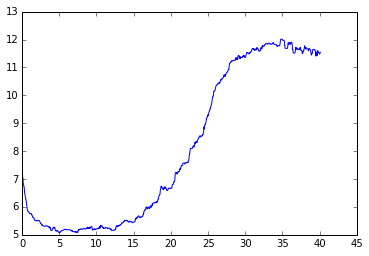

In [559]:
# 0.03 learning rate Jonathan weights

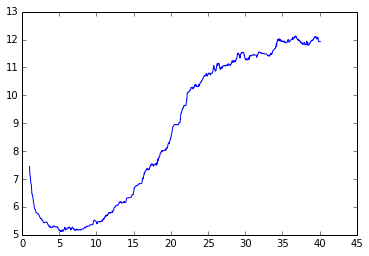

In [553]:
# 0.03 learning rate Jonathan weights

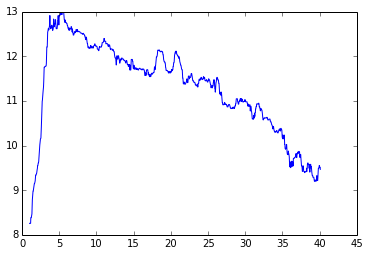

In [547]:
# 0.3 learning rate Jonathan weights

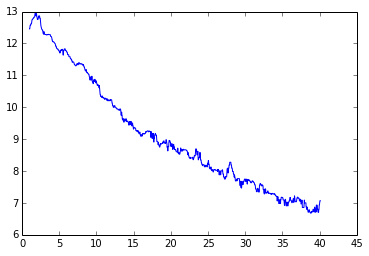

In [541]:
# 0.3 learning rate, torch weight init

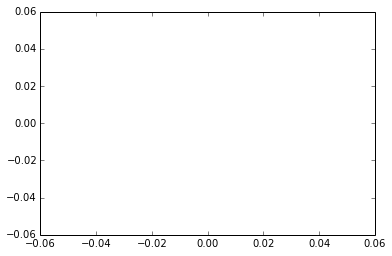

In [431]:
r= epoch_error#median_smoothing(epoch_error, window=500)

plt.plot(range(len(r)), r)

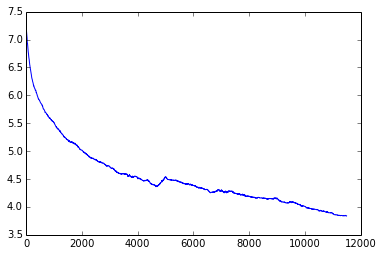

In [18]:
plottable = median_smoothing(train_error.epoch_error, 300)
#plottable = median_smoothing(train_error.epoch_error, 3)

plt.plot(range(len(plottable)), plottable)

In [40]:
solver.__class__ =Solver

In [34]:
show_reconstructions(model, (["Where", "are","my","friends","?"],[]))

TRANSLATING: Where are my friends ?
REFERENCE:   

    0.000241 => En ce qui ? **EOS**
    0.000108 => En ce qui sont ? **EOS**
    0.000021 => Où est - ce ? **EOS**
    0.000019 => Où est - ce qui ? **EOS**
    0.000003 => En ce qui sont - ? **EOS**


In [95]:
np.nan

nan

In [37]:
type(np.arange(1, 10))

numpy.ndarray